In [1]:
import numpy as np
import casadi as ca
import matplotlib.pyplot as plt
from Helpers import *

In [ ]:
def optimizationofmpcproblem(dt,Horizon,w1,w2,r,end,estimate_now):
        # State variables: x (cart position), x_dot, theta (pendulum angle), theta_dot
    theta = ca.SX.sym("theta",2)
    omega = ca.SX.sym("omega",2)
    tau = ca.SX.sym("tau",2)
    state = ca.vertcat(theta,omega,tau)

    # Control input: Force applied to the cart
    u = ca.SX.sym("u",2)
    control = ca.vertcat(u)

    # Equations of motion (nonlinear dynamics)
    cos_elbow = ca.cos(theta[1])
    sin_elbow = ca.sin(theta[1])
    DetM = a1*a3-a3*a3-a2*a2*cos_elbow*cos_elbow
    Minv = np.array([[a3,-a3-a2*cos_elbow],
                [-a3-a2*cos_elbow,a1+2*a2*cos_elbow]])/DetM


    C = ca.SX(np.array([-omega[1]*(2*omega[0]+omega[1])*a2*sin_elbow,omega[0]*omega[0]*a2*sin_elbow]))

    Bdyn = ca.SX(np.array([[0.25,0.05],[0.05,0.25]]))   
    #Bdyn = ca.SX(np.array([[0.74,0.1],[0.1,0.82]]))           
    jerk = Minv @ (tau-C-Bdyn@omega)
    taudot = (u-tau)/.06
    xdot = ca.vertcat(omega,jerk,taudot)

    # CasADi function for system dynamics
    f = ca.Function("f", [state, control], [xdot])

    # Define optimization variables
    opti = ca.Opti()
    X = opti.variable(6, Horizon )  # State trajectory
    U = opti.variable(2, Horizon-1)  # Control inputs

    # Initial and target states
    X0 = opti.parameter(6)
    X_targ = np.array([end[0],end[1],0, 0,0,0])  

    # Objective function and constraints
    cost = 0
    for k in range(Horizon-1):
        x_k = X[:, k]
        u_k = U[:, k]
        cost += r*ca.sumsqr(u_k)  # Quadratic cost
        
        # System dynamics constraint using Euler discretization
        x_next = X[:, k] + dt * f(x_k, u_k)
        opti.subject_to(X[:, k + 1] == x_next)

    # Final state cost
    cost += w1 * ca.sumsqr(X[:2, -1] - X_targ[:2])
    cost += w2*ca.sumsqr(X[2:4, -1] - X_targ[2:4])

    opti.minimize(cost)

    # Initial condition constraint
    opti.subject_to(X[:, 0] == X0)

    # Solver setup
    opts = {"print_time":0,'ipopt.hessian_approximation': 'exact'}
    opti.solver("ipopt",opts)
    opti.set_value(X0, estimate_now)
    sol = opti.solve()
    return sol,U,f

# Discretization parameters
def MPC(Duration,start,end,w1,w2,r,Horizon = 20,dt = 0.005):


    

    # Simulation
    Duration
    n_steps = int(Duration / dt)
    states = np.zeros((6, n_steps))
    controls = np.zeros((2, n_steps-1))
    state_now = np.array([start[0], start[1],0, 0,0,0])    # Slightly off-balance initial condition
    endsteps = 0
    states[:,0] = state_now
    for t in range(n_steps-1):
        if (t+Horizon) <= n_steps : 
            sol,U,f = optimizationofmpcproblem(dt,Horizon,w1,w2,r,end,state_now)
            
        else : endsteps +=1
        u_opt = sol.value(U[:, endsteps])
        controls[:, t] = u_opt
        motor_noise = np.zeros(6)
        motor_noise[4:6] = np.random.normal(0,1e-3,2)
        # Update state using the first control action
        state_now = state_now + dt * f(state_now, u_opt).full().flatten() + motor_noise
        states[:, t+1] = state_now

    # Plot results
    plt.figure(figsize=(10, 16))

    plt.subplot(3, 1, 1)
    plt.plot(np.linspace(0, Duration, n_steps), states[2, :], label="Shoulder ",color = "#990000")
    plt.plot(np.linspace(0, Duration, n_steps), states[3,:], label="Elbow",linestyle = "-.",color = "#990000")
    plt.axhline(0, color='grey', linestyle='--')
    plt.legend()
    plt.xlabel("Time (s)")
    plt.ylabel("Force (N)")
    plt.subplot(3, 1, 2)
    s = states[0]
    e = states[1]
    X = np.cos(s+e)*33+np.cos(s)*30
    Y = np.sin(s+e)*33+np.sin(s)*30
    plt.plot(X,Y,color = "#990000")

    plt.axis("equal")

    plt.subplot(3, 1, 3)
    plt.plot(np.linspace(0, Duration, n_steps), states[0, :], label="Shoulder ",color = "#990000")
    plt.plot(np.linspace(0, Duration, n_steps), states[1,:], label="Elbow",linestyle = "-.",color = "#990000")
    return controls

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1902
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      794

Total number of variables............................:      638
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.0766359e+04 1.22e+00 7.88e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

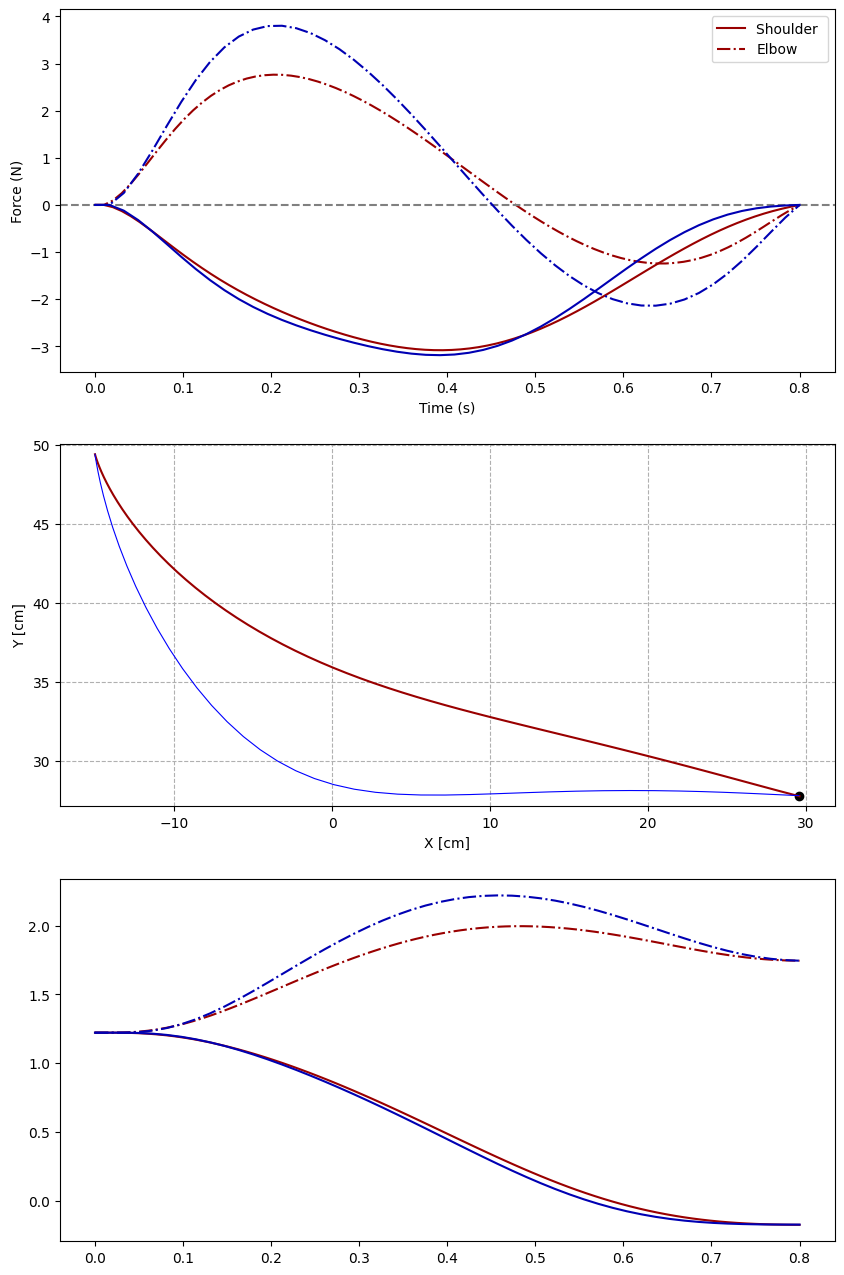

In [11]:
umpc = MPC(.8,[70/180*pi,70/180*pi],[-10/180*pi,100/180*pi],1e4,1,1e-4,80,dt = .01)
targ = ToCartesian(np.array([-10/180*pi,100/180*pi]))
start = ToCartesian(np.array([70/180*pi,70/180*pi]))
from ILQGController import *
plt.subplot(3,1,2)
_,_,uilqg,x=ILQG(.8,1e4,1,1e-4,targ,50,start)
print(np.sum(uilqg**2)*1e-4)
print(np.sum(umpc**2)*1e-4)
plt.subplot(3,1,1)
plt.plot(np.linspace(0,.8,50),x[:,2],color = "#0000b3")
plt.plot(np.linspace(0,.8,50),x[:,3],linestyle = "-.",color = "#0000b3")


plt.subplot(3,1,3)
plt.plot(np.linspace(0,.8,50),x[:,0],color = "#0000b3")
plt.plot(np.linspace(0,.8,50),x[:,1],linestyle = "-.",color = "#0000b3")

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1902
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      794

Total number of variables............................:      638
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.2184697e+04 1.92e+00 7.27e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

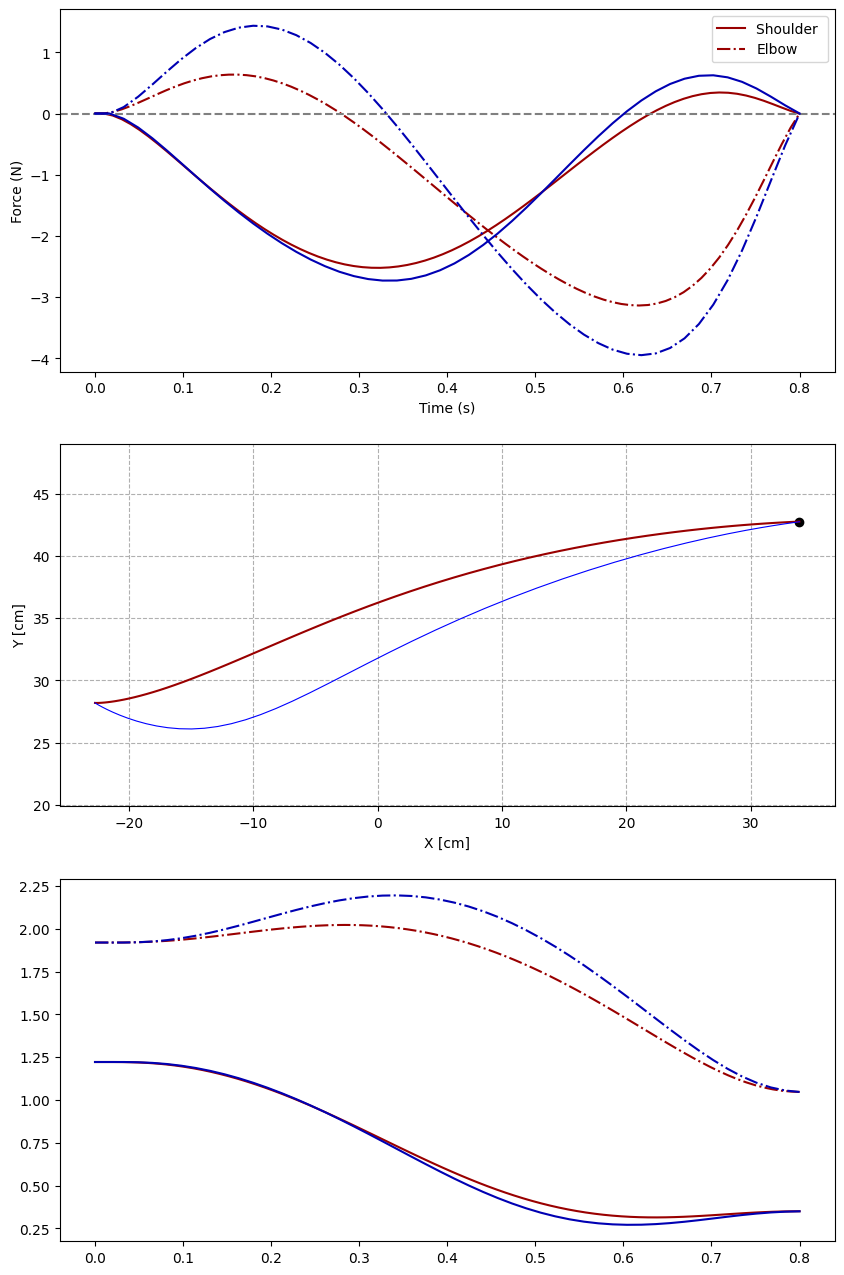

In [13]:
umpc = MPC(.8,[70/180*pi,110/180*pi],[20/180*pi,60/180*pi],1e4,1,1e-4,80,dt = .01)
targ = ToCartesian(np.array([20/180*pi,60/180*pi]))
start = ToCartesian(np.array([70/180*pi,110/180*pi]))
from ILQGController import *
plt.subplot(3,1,2)
_,_,uilqg,x=ILQG(.8,1e4,1,1e-4,targ,50,start)
print(np.sum(uilqg**2)*1e-4)
print(np.sum(umpc**2)*1e-4)
plt.subplot(3,1,1)
plt.plot(np.linspace(0,.8,50),x[:,2],color = "#0000b3")
plt.plot(np.linspace(0,.8,50),x[:,3],linestyle = "-.",color = "#0000b3")


plt.subplot(3,1,3)
plt.plot(np.linspace(0,.8,50),x[:,0],color = "#0000b3")
plt.plot(np.linspace(0,.8,50),x[:,1],linestyle = "-.",color = "#0000b3")

In [8]:
def optimizationofmpcproblem2(dt,Horizon,w1,w2,r,end,estimate_now):
        # State variables: x (cart position), x_dot, theta (pendulum angle), theta_dot
    theta = ca.SX.sym("theta",2,1)
    omega = ca.SX.sym("omega",2,1)
    state = ca.vertcat(theta,omega)
    a1 = ca.SX(0.0477 + 0.0588 + 0.3* 0.3*1.44)
    a2 = ca.SX(0.3 * 0.21*1.44)
    a3 = ca.SX(0.0588)

    # Control input: Force applied to the cart
    u = ca.SX.sym("u",6)
    control = ca.vertcat(u)

    # Equations of motion (nonlinear dynamics)
    cos_elbow = ca.cos(theta[1])
    sin_elbow = ca.sin(theta[1])
    Minv = ca.inv(ca.vertcat(
    ca.horzcat(a1+2*a2*cos_elbow, a3 +a2 * cos_elbow),
    ca.horzcat(a3 +a2 * cos_elbow, a3)
))

    C = ca.vertcat(
    -omega[1] * (2 * omega[0] + omega[1]) * a2 * sin_elbow,
    omega[0] * omega[0] * a2 * sin_elbow
) 


    

    A = ca.DM([
    [0.04, 0.04, 0, 0, 0.028, 0.028],
    [0, 0, 0.025, 0.025, 0.035, 0.035]
]).T  

    lmlo = ca.SX([0.09076,-0.02793,0.05672,0.00436,0.14294,-0.01343])
    ri = ca.SX([-0.03491,0.03491,-0.02182,0.02182,-0.05498,0.05498])
    T = ca.diag(810.8 + 1621.6 * ca.reshape(u, (6, 1)))@(-lmlo+ri*u+(A@theta))+ca.diag(54.1 + 108.1 * ca.reshape(u, (6, 1)))@(A@omega)
    #print((ca.diag(810.8 + 1621.6 * ca.reshape(u, (6, 1)))*(-lmlo+ri*u+(A@theta))).shape,(ca.diag(54.1 + 108.1 * ca.reshape(u, (6, 1)))*(A@omega)).shape)
    
    tau = -A.T@T
    
    jerk = Minv @ (tau-C)
    
    xdot = ca.vertcat(omega,jerk)

    # CasADi function for system dynamics
    f = ca.Function("f", [state, control], [xdot])

    # Define optimization variables
    opti = ca.Opti()
    X = opti.variable(4, Horizon )  # State trajectory
    U = opti.variable(6, Horizon-1)  # Control inputs

    # Initial and target states
    X0 = opti.parameter(4)
    X_targ = ca.vertcat(end[0], end[1], 0, 0)

    # Objective function and constraints
    cost = 0
    for k in range(Horizon-1):
        x_k = X[:, k]
        u_k = U[:, k]
        cost += r*ca.sumsqr(u_k)  # Quadratic cost
        
        # System dynamics constraint using Euler discretization
        x_next = X[:, k] + dt * f(x_k, u_k)
        opti.subject_to(X[:, k + 1] == x_next)

    # Final state cost
    cost += w1 * ca.sumsqr(X[:2, -1] - X_targ[:2])
    cost += w2*ca.sumsqr(X[2:4, -1] - X_targ[2:4])

    opti.minimize(cost)

    # Initial condition constraint
    opti.subject_to(X[:, 0] == X0)

    # Solver setup
    opts = {"print_time":0,'ipopt.hessian_approximation': 'exact'}
    opti.solver("ipopt",opts)
    opti.set_value(X0, estimate_now)
    sol = opti.solve()
    return sol,U,f

# Discretization parameters
def MPC2(Duration,start,end,w1,w2,r,Horizon = 20,dt = 0.005):


    

    # Simulation
    Duration
    n_steps = int(Duration / dt)
    states = np.zeros((4, n_steps))
    controls = np.zeros((6, n_steps-1))
    state_now = np.array([start[0], start[1],0, 0])    # Slightly off-balance initial condition
    endsteps = 0
    states[:,0] = state_now
    for t in range(n_steps-1):
        if (t+Horizon) <= n_steps : 
            sol,U,f = optimizationofmpcproblem2(dt,Horizon,w1,w2,r,end,state_now)
            
        else : endsteps +=1
        u_opt = sol.value(U[:, endsteps])
        controls[:, t] = u_opt
        # Update state using the first control action
        state_now = state_now + dt * f(state_now, u_opt).full().flatten()
        states[:, t+1] = state_now

    # Plot results
    plt.figure(figsize=(10, 16))

    plt.subplot(2, 1, 1)
    plt.plot(np.linspace(0, Duration, n_steps), states[2, :], label="Shoulder ",color = "#990000")
    plt.plot(np.linspace(0, Duration, n_steps), states[3,:], label="Elbow",linestyle = "-.",color = "#990000")
    plt.axhline(0, color='grey', linestyle='--')
    plt.legend()
    plt.xlabel("Time (s)")
    plt.ylabel("Force (N)")
    plt.subplot(2, 1, 2)
    s = states[0]
    e = states[1]
    X = np.cos(s+e)*35+np.cos(s)*30
    Y = np.sin(s+e)*35+np.sin(s)*30
    plt.plot(X,Y,color = "#990000")
    plt.grid()
    plt.axis("equal")

    return controls

In [6]:
s = 1
e = .7
X = np.cos(s+e)*35+np.cos(s)*30
Y = np.sin(s+e)*35+np.sin(s)*30

print(X,Y)

11.699511875700829 59.9523979100733


This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1376
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1523

Total number of variables............................:      494
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      200
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.4900000e+00 1.19e+01 3.55e-02  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

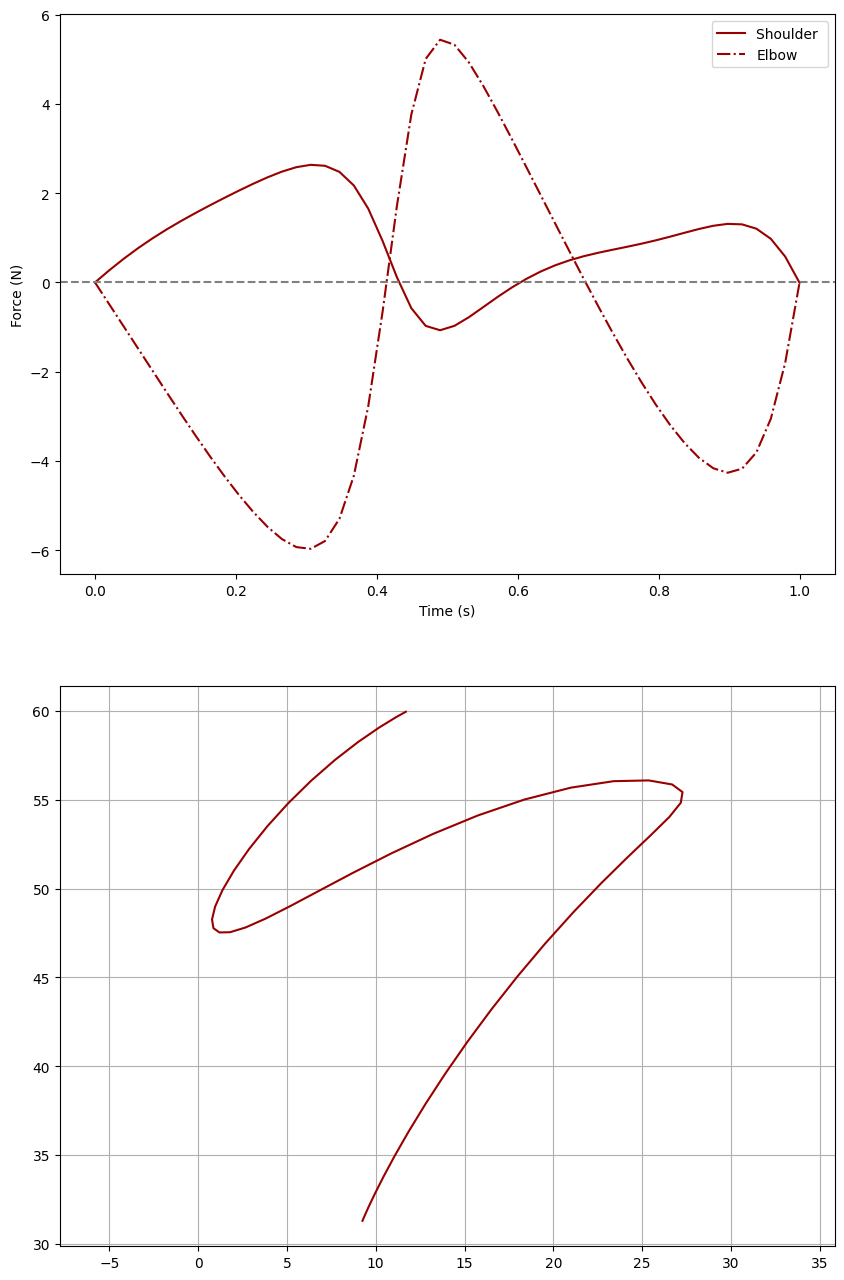

In [9]:
from ILQGMuscle import *
st = [0.1,2.1]
tg= [1,.7]
umpc = MPC2(1,st,tg,1,1e-3,1e-4,50,dt = .02)

In [ ]:
def optimizationofmpcproblem3(dt,Horizon,w1,w2,r,end,estimate_now):
        # State variables: x (cart position), x_dot, theta (pendulum angle), theta_dot
    theta = ca.SX.sym("theta",2,1)
    omega = ca.SX.sym("omega",2,1)
    a =ca.SX.sym("a",6,1)
    state = ca.vertcat(theta,omega,a)
    a1 = ca.SX(0.0477 + 0.0588 + 0.3* 0.3*1.44)
    a2 = ca.SX(0.3 * 0.21*1.44)
    a3 = ca.SX(0.0588)

    # Control input: Force applied to the cart
    u = ca.SX.sym("u",6)
    control = ca.vertcat(u)

    # Equations of motion (nonlinear dynamics)
    cos_elbow = ca.cos(theta[1])
    sin_elbow = ca.sin(theta[1])
    Minv = ca.inv(ca.vertcat(
    ca.horzcat(a1+2*a2*cos_elbow, a3 +a2 * cos_elbow),
    ca.horzcat(a3 +a2 * cos_elbow, a3)
))

    C = ca.vertcat(
    -omega[1] * (2 * omega[0] + omega[1]) * a2 * sin_elbow,
    omega[0] * omega[0] * a2 * sin_elbow
) 
    T = A@(Fl@Vv+Fp)
    tau = M@T
    
    acc = Minv @ (tau-C-Bdyn@omega)
    filter_constant = ca.if_else(control > a, 
                     0.066 + control * (0.05 - 0.066),  # If control > state
                     0.066)
    t = ca.Function("t", [ control,a], [filter_constant])
    actuation = (u-a)/t(u,a)
    
    xdot = ca.vertcat(omega,acc,actuation)
    # CasADi function for system dynamics
    f = ca.Function("f", [state, control], [xdot])

    # Define optimization variables
    opti = ca.Opti()
    X = opti.variable(4, Horizon )  # State trajectory
    U = opti.variable(6, Horizon-1)  # Control inputs

    # Initial and target states
    X0 = opti.parameter(4)
    X_targ = ca.vertcat(end[0], end[1], 0, 0)

    # Objective function and constraints
    cost = 0
    for k in range(Horizon-1):
        x_k = X[:, k]
        u_k = U[:, k]
        cost += r*ca.sumsqr(u_k)  # Quadratic cost
        
        # System dynamics constraint using Euler discretization
        x_next = X[:, k] + dt * f(x_k, u_k)
        opti.subject_to(X[:, k + 1] == x_next)

    # Final state cost
    cost += w1 * ca.sumsqr(X[:2, -1] - X_targ[:2])
    cost += w2*ca.sumsqr(X[2:4, -1] - X_targ[2:4])

    opti.minimize(cost)

    # Initial condition constraint
    opti.subject_to(X[:, 0] == X0)

    # Solver setup
    opts = {"print_time":0,'ipopt.hessian_approximation': 'exact'}
    opti.solver("ipopt",opts)
    opti.set_value(X0, estimate_now)
    sol = opti.solve()
    return sol,U,f

# Discretization parameters
def MPC3(Duration,start,end,w1,w2,r,Horizon = 20,dt = 0.005):


    

    # Simulation
    Duration
    n_steps = int(Duration / dt)
    states = np.zeros((4, n_steps))
    controls = np.zeros((6, n_steps-1))
    state_now = np.array([start[0], start[1],0, 0])    # Slightly off-balance initial condition
    endsteps = 0
    states[:,0] = state_now
    for t in range(n_steps-1):
        if (t+Horizon) <= n_steps : 
            sol,U,f = optimizationofmpcproblem3(dt,Horizon,w1,w2,r,end,state_now)
            
        else : endsteps +=1
        u_opt = sol.value(U[:, endsteps])
        controls[:, t] = u_opt
        # Update state using the first control action
        state_now = state_now + dt * f(state_now, u_opt).full().flatten()
        states[:, t+1] = state_now

    # Plot results
    plt.figure(figsize=(10, 16))

    plt.subplot(2, 1, 1)
    plt.plot(np.linspace(0, Duration, n_steps), states[2, :], label="Shoulder ",color = "#990000")
    plt.plot(np.linspace(0, Duration, n_steps), states[3,:], label="Elbow",linestyle = "-.",color = "#990000")
    plt.axhline(0, color='grey', linestyle='--')
    plt.legend()
    plt.xlabel("Time (s)")
    plt.ylabel("Force (N)")
    plt.subplot(2, 1, 2)
    s = states[0]
    e = states[1]
    X = np.cos(s+e)*35+np.cos(s)*30
    Y = np.sin(s+e)*35+np.sin(s)*30
    plt.plot(X,Y,color = "#990000")
    plt.grid()
    plt.axis("equal")

    return controls